<a href="https://colab.research.google.com/github/M-Jahanzaib6062/PyTorch-Beginner-to-Advanced/blob/main/06_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**06. PyTorch Transfer Learning**

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##1. Get Data

In [ ]:
import zipfile
import requests
from pathlib import Path

data_path = Path('project/data/')
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f'Path exists!')
else:
  image_path.mkdir(parents = True, exist_ok = True)

  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(request.content)

  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip') as zip_ref:
    zip_ref.extractall(image_path)

In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

##2. Create Datasets and DataLoaders

In [ ]:
%%writefile project/helper_scripts/data_setup.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def GetDataLoaders(
                  train_path : str,
                  test_path : str,
                  transform : transforms.Compose,
                  batch_size : int,
                  workers : int
              ):
  train_dataset = datasets.ImageFolder(root = train_path,
                                      transform = transform)
  test_dataset = datasets.ImageFolder(root = test_path,
                                      transform = transform)
  class_names = train_dataset.classes

  train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = batch_size,
                                shuffle = True,
                                num_workers = workers,
                                pin_memory = True)
  test_dataloader = DataLoader(dataset = test_dataset,
                               batch_size = batch_size,
                               shuffle = False,
                               num_workers = workers,
                               pin_memory = True)
  return train_dataloader, test_dataloader, class_names

Writing project/helper_scripts/data_setup.py


In [ ]:
from project.helper_scripts.data_setup import GetDataLoaders

In [ ]:
manual_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

])

In [ ]:
import os

torch.manual_seed(42)
torch.cuda.manual_seed(42)
batch_size = 32
workers = os.cpu_count()
train_dataloader, test_dataloader, class_names = GetDataLoaders(train_dir,
                                                                test_dir,
                                                                manual_transform,
                                                                batch_size, workers)
print(class_names)

['pizza', 'steak', 'sushi']


In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader, test_dataloader, class_names = GetDataLoaders(train_dir,
                                                                test_dir,
                                                                auto_transform,
                                                                batch_size,
                                                                workers)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7be62884af10>,
 ['pizza', 'steak', 'sushi'])

##3. Getting a pretrained model

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 70.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
summary(model, input_size = (32, 3, 224, 224),col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names), bias = True)
).to(device)

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

##4. Train Model


In [ ]:
%%writefile project/helper_scripts/engine.py

import torch
from tqdm.auto import tqdm

def TrainStep(
                model : torch.nn.Module,
                dataloader : torch.utils.data.DataLoader,
                loss_func : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                device
            ):
  model.train()
  train_accuracy, train_loss = 0, 0
  for X, y in dataloader:
    X = X.to(device)
    y = y.to(device)
    logits = model(X)
    loss = loss_func(logits, y)
    train_loss += loss.item()
    y_pred = torch.argmax(torch.softmax(logits, dim = 1), dim = 1)
    train_accuracy += (y == y_pred).sum().item() / len(y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_accuracy /= len(dataloader)
  return train_loss, train_accuracy

def TestStep(
              model : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_func : torch.nn.Module,
              device
          ):
  model.eval()
  test_loss, test_accuracy = 0, 0
  with torch.inference_mode():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      loss = loss_func(logits, y)
      test_loss += loss.item()
      y_pred = torch.argmax(torch.softmax(logits, dim = 1), dim = 1)
      test_accuracy += (y == y_pred).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)
  return test_loss, test_accuracy

def Train(
            model : torch.nn.Module,
            train_dataloader : torch.utils.data.DataLoader,
            test_dataloader : torch.utils.data.DataLoader,
            loss_func : torch.nn.Module,
            optimizer : torch.optim.Optimizer,
            epochs : int,
            device
        ):
  results = {
      'train_loss' : [],
      'train_accuracy' : [],
      'test_loss' : [],
      'test_accuracy' : []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = TrainStep(model, train_dataloader,
                                            loss_func, optimizer, device)
    test_loss, test_accuracy = TestStep(model, test_dataloader,
                                        loss_func, device)
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_accuracy:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_accuracy:.4f}"
      )

    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_accuracy)
    results['test_loss'].append(test_loss)
    results['test_accuracy'].append(test_accuracy)

  return results


Writing project/helper_scripts/engine.py


In [ ]:
from project.helper_scripts.engine import Train

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

results = Train(model, train_dataloader, test_dataloader, loss_func, optimizer, epochs, device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561


In [ ]:
try:
  from project.helper_scripts.helper_functions import plot_loss_curves
except:
  import requests
  with open('project/helper_scripts/helper_functions.py', 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f.write(request.content)
  from project.helper_scripts.helper_functions import plot_loss_curves


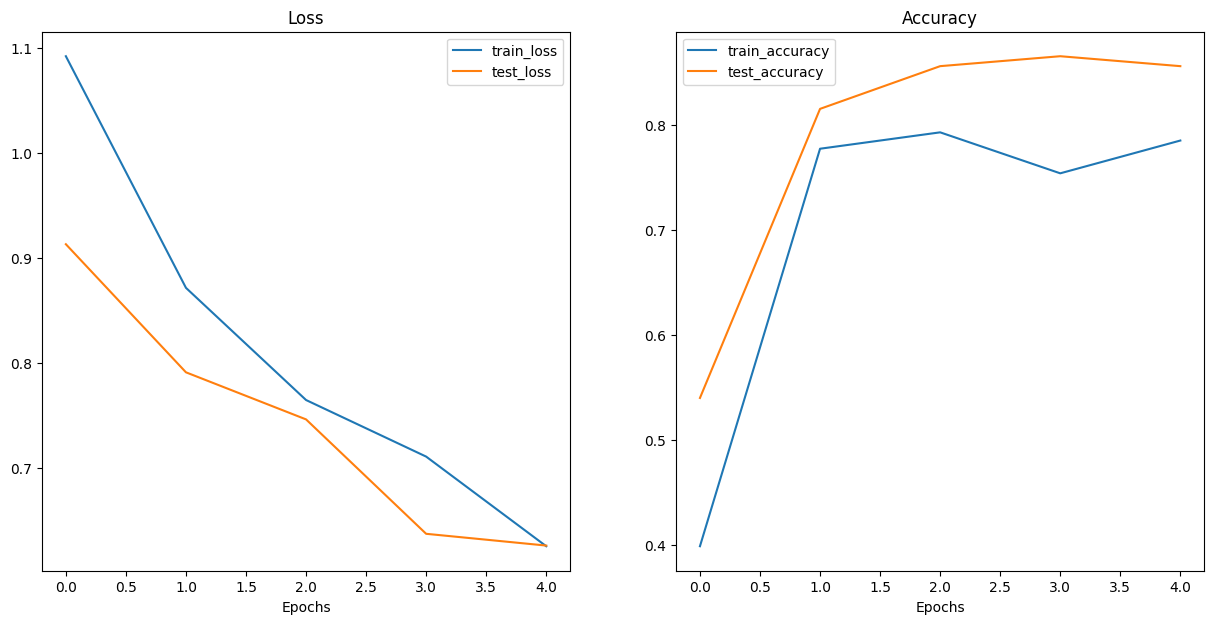

In [ ]:
results_new = {}
results_new['train_loss'] = results['train_loss']
results_new['train_acc'] = results['train_accuracy']
results_new['test_loss'] = results['test_loss']
results_new['test_acc'] = results['test_accuracy']
plot_loss_curves(results_new)

##6. Making Prediction on Image from Test-Set

In [ ]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt

def PredPlotImages(model : torch.nn.Module,
                   img_path : str,
                   img_size : Tuple[int, int],
                   class_names : List,
                   transform : torchvision.transforms = None,
                   device: torch.device = 'cpu'):

  image = Image.open(img_path)
  if transform is not None:
    transformed_image = transform(image)
  else:
    transform = transforms.Compose([
        transforms.Resize(size = img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])
    transformed_image = transform(image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    logits = model(torch.unsqueeze(transformed_image, dim = 0).to(device))
  probs = torch.softmax(logits, dim = 1)
  y_pred = torch.argmax(probs, dim = 1)
  plt.figure()
  plt.imshow(image)
  plt.title(f'Pred : {class_names[y_pred]} | Prob : {probs.max():.3f}')
  plt.axis(False)




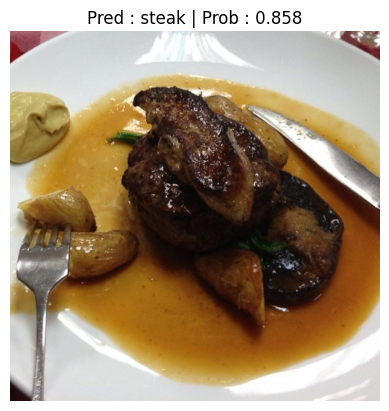

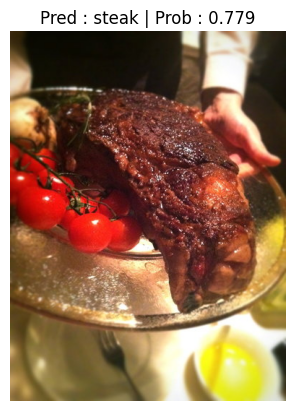

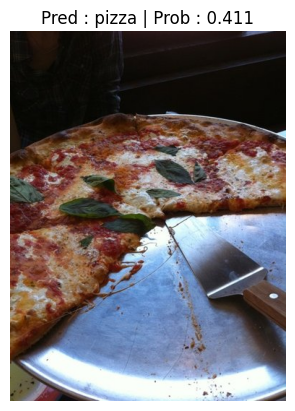

In [ ]:
import random
from pathlib import Path

random.seed(42)

n_samples = 3

image_path_list = list(Path(test_dir).glob('*/*.jpg'))
random_image_paths = random.sample(image_path_list, k = n_samples)
for image_path in random_image_paths:
  PredPlotImages(model, image_path, (224,224), class_names,
                 device = device)